### 1. Import package 

In [1]:
import os, sys
sys.path.append('../src/')
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
import shap
from activityFeature_engineer import *
from pred_model import *
from AppAct_df import *

### ignore the warnings ###

/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/minhpham/Desktop/Ongo/Ongo/OngoEnv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2. Load data of app activities

In [2]:
### CHANGE HERE ###
data_dir = '../../Ongo/data/S3/AppEventData/'
result_fl = '../results/'
if not os.path.exists(result_fl):
    os.makedirs(result_fl)

In [3]:
CommunityMember, SubscriptionHistory, ActivityComplete, SessionCompleted, \
LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed = process_AppAct_df (data_dir)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### 3. Sample trial users

##### 3.1 Remove Legacy/Hubspot and Administrator users

In [4]:
CommunityMember_filter = CommunityMember[CommunityMember['membershipName'] != 'Legacy']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Administrator']
CommunityMember_filter = CommunityMember_filter[CommunityMember_filter['membershipSource'] != 'Hubspot']
CommunityMember_filter_id = CommunityMember_filter.user.unique()

##### 3.2 Select users with purchase and users with free trials

In [5]:
SubscriptionHistory_purchase = SubscriptionHistory[SubscriptionHistory.event == 'subscription-purchase']
SubscriptionHistory_freeTrial = SubscriptionHistory[SubscriptionHistory.event == 'subscription-free-trial']
SubscriptionHistory_purchase_id = SubscriptionHistory_purchase.user.unique()
SubscriptionHistory_freeTrial_id = SubscriptionHistory_freeTrial.user.unique()

##### 3.3 Select users with purchase converted from trial

In [6]:
convertedFromTrial_id = SubscriptionHistory[SubscriptionHistory.convertedFromTrial == bool('True')].user.unique()
nonconverted_trial = set(SubscriptionHistory_freeTrial_id).difference(SubscriptionHistory_purchase_id)
converted_trial = set(SubscriptionHistory_freeTrial_id).intersection(SubscriptionHistory_purchase_id).intersection(convertedFromTrial_id)

##### 3.4 Select trial users that are not Legacy/Hubspot/Admin

In [7]:
nonconverted = nonconverted_trial.intersection(CommunityMember_filter_id)
converted = converted_trial.intersection(CommunityMember_filter_id)
IDs = list(nonconverted) + list(converted)
# print (f'Trial users: {len(nonconverted)} churned, {len(converted)} converted')

### 4. EDA: How many days do users take from the first sign up to subscribing for trials?

In [8]:
b4Trial_dict = {}
for ID in IDs:
    trial_start = pd.to_datetime(SubscriptionHistory[(SubscriptionHistory['user']==ID)&(SubscriptionHistory['event']=='subscription-free-trial')]['eventDate'].values)
    create_date = pd.to_datetime(CommunityMember[(CommunityMember['user']==ID)]['createdAt'].values)
    b4Trial_dict[ID] = (trial_start-create_date).days.values[0]
    
b4Trial_df = pd.DataFrame(list(b4Trial_dict.items()), columns = ['user', 'days_create2Trial']).set_index(['user'])
b4Trial_df['Converted'] = bool(True)
b4Trial_df.loc[list(nonconverted), 'Converted'] =  bool(False)

b4Trial_filter = b4Trial_df[(b4Trial_df.days_create2Trial > 0)]

### Confidentiality: data is not shown ###
# print ('Users that created an account before trial')
# print (b4Trial_filter.groupby(['Converted']).agg(['count']), '\n')
# print ('The number of days before trial of these users \n X-axis = number of days before trials \n y-axis = freq')
# print (b4Trial_filter.days_create2Trial.hist(by=b4Trial_filter.Converted))

## 5. Feature engineering for app engagement activities
Time periods: 7 days before trial, 7 days through trial, first 2 days of trial


Variables: 
- freq: the number of times of an app activity
- cons: the number of consecutive days of an app activity
- daily ave: the daily average of number of times
- norm: the daily ave is normalized across users

In [9]:
# During trial: freq, cons
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
trial_activity = feature_duration(DFs, IDs, SubscriptionHistory)

In [10]:
# During first 2 days of trial: freq
DFs = trial_activity['ActivityComplete']['filter'], trial_activity['SessionCompleted']['filter'], \
trial_activity['LibrarySelectedTab']['filter'], trial_activity['ScreenViewed']['filter'], \
trial_activity['AppForeground']['filter'], trial_activity['SessionViewed']['filter']
trial2_activity = feature_duration(DFs, IDs, SubscriptionHistory, duration = 3, consecutive = False)

In [11]:
# Before trial: freq, daily ave, norm
DFs = ActivityComplete, SessionCompleted, LibrarySelectedTab, ScreenViewed, AppForeground, SessionViewed
b4_activity = feature_duration(DFs, IDs, SubscriptionHistory, add = False, consecutive = False, cal_ave = True, dayDF = b4Trial_filter)

In [12]:
# 7 days before and 7 days during trial: cons
DFs = pd.concat([trial_activity['ActivityComplete']['filter'], b4_activity['ActivityComplete']['filter']]), \
pd.concat([trial_activity['SessionCompleted']['filter'], b4_activity['SessionCompleted']['filter']]), \
pd.concat([trial_activity['LibrarySelectedTab']['filter'], b4_activity['LibrarySelectedTab']['filter']]), \
pd.concat([trial_activity['ScreenViewed']['filter'], b4_activity['ScreenViewed']['filter']]), \
pd.concat([trial_activity['AppForeground']['filter'], b4_activity['AppForeground']['filter']]), \
pd.concat([trial_activity['SessionViewed']['filter'], b4_activity['SessionViewed']['filter']])

b4_duringTrial_activity = feature_duration(DFs, IDs, SubscriptionHistory, filter = False, freq = False)

## 6. Feature dataframe
Column 'Converted': True = converted, False = nonconverted 

In [13]:
# Converted/Churned Trial Users - Select users that do not have ambiguous days before trial
feature_df = b4Trial_df[(b4Trial_df.days_create2Trial >= 0)]

In [14]:
# Features: Goal & Experience
CommunityMember_join = CommunityMember[['user','goal', 'exp']].set_index('user')
feature_df = feature_df.join(CommunityMember_join)
feature_df = feature_df[feature_df.goal.notnull()]
feature_df = feature_df[feature_df.exp.notnull()]
# one hot encoding
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['goal'], prefix='goal')],axis=1)
feature_df.drop(['goal'],axis=1, inplace=True)
feature_df = pd.concat([feature_df,pd.get_dummies(feature_df['exp'], prefix='exp')],axis=1)
feature_df.drop(['exp'],axis=1, inplace=True)

In [15]:
# Append app activity features
def append_feature_df (feature, pre_column, renamed_column, feature_df):
    feature_renamed = feature.rename(columns={pre_column:renamed_column})
    feature_df_new = feature_df.join(feature_renamed[renamed_column])
    return feature_df_new
    
def iterate_feature_type (df, df_name, feature_df, feature_types= [('norm', 'normed_daily_ave'), \
('cons', 'number_consecutive_day'), ('ave', 'daily_ave'), ('freq', 'count')]):
    for activity_name in df:
        for metrics, metric_name in feature_types:
            try:
                feature = df[activity_name][metrics]
                new_name = df_name+'_'+ activity_name+'_'+metrics
                feature_df = append_feature_df (feature, metric_name, new_name, feature_df)
            except:
                pass
    return feature_df
            
feature_df_new = iterate_feature_type (b4_activity, 'b4Trial', feature_df)
feature_df_new = iterate_feature_type (trial_activity, '7dTrial', feature_df_new)
feature_df_new = iterate_feature_type (trial2_activity, '2dTrial', feature_df_new)
feature_df_new = iterate_feature_type (b4_duringTrial_activity, 'b4_duringTrial', feature_df_new)

feature_df_new = feature_df_new.fillna(0)

## 7. Model selection and tuning

In [18]:
# define datasets
X = feature_df_new.loc[:,feature_df_new.columns!='Converted']
y = feature_df_new['Converted']
try:
    X_p= pd.read_csv('../../Ongo/results/X.csv', index_col='user')
    X = X.loc[X_p.index,:] # to reproduce the same indexed dataframe
except:
    pass
X = X.astype('int32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
### save dataframes ###
# X.to_csv('../../Ongo/results/X.csv')
# y.to_csv('../../Ongo/results/y.csv')

##### 5-fold cross validation, accompanied with Recursive Feature Elimination 

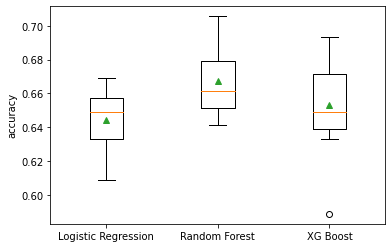

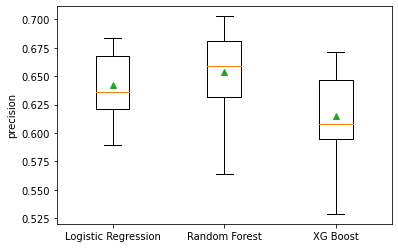

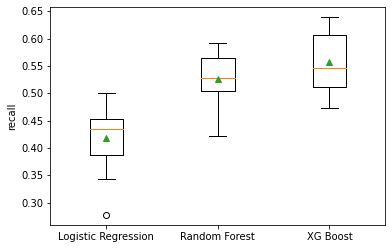

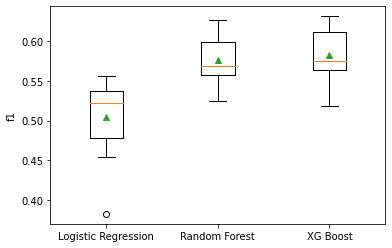

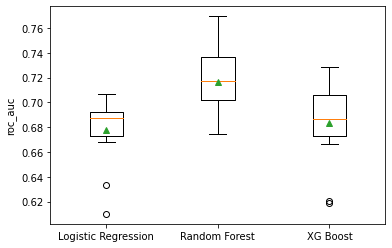

In [44]:
def get_models():
	models = dict()
    # decision tree
	rfe = RFECV(estimator=DecisionTreeClassifier())
	model = DecisionTreeClassifier()
	models['Decision Tree'] = Pipeline(steps=[('s',rfe),('m',model)])
    # lr
	rfe = RFECV(estimator=LogisticRegression())
	model = LogisticRegression()
	models['Logistic Regression'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFECV(estimator=RandomForestClassifier())
	model = RandomForestClassifier()
	models['Random Forest'] = Pipeline(steps=[('s',rfe),('m',model)])
    # XGB
	rfe = RFECV(estimator=XGBClassifier())
	model = XGBClassifier()
	models['XG Boost'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
measures = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = {}
    for score in measures:
        scores[score] = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = {}, list()
for score in measures:
    results[score] = list()
for name, model in models.items():
    names.append(name)
    scores = evaluate_model(model, X_train, y_train)
    for s in scores:
        results[s].append(scores[s])
	

# plot model performance for comparison
for score in measures:
    plt.boxplot(results[score][1:4], labels=names[1:4], showmeans=True)
    plt.ylabel(score, fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.savefig(f'../results/modelCV_{score}.png', dpi = 400, transparent = True)
    plt.show()

##### Grid search for hyperparameters

F1 score: 0.5983606557377049
accuracy: 0.684887459807074
Confusion Matrix
[[140  25]
 [ 73  73]]


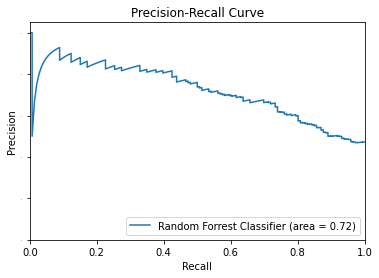

In [86]:
# baseline model without Recursive feature elimination
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
baseline_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
baseline_rfc.fit(X_train, y_train)
y_pred_baseline = baseline_rfc.predict(X_test)
print ('best parameter: ', baseline_rfc.best_params_)
plot_AUC(baseline_rfc, X_test, y_test)

best parameter:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}
48 selected features
F1 score: 0.6065573770491803
accuracy: 0.6913183279742765
Confusion Matrix
[[141  24]
 [ 72  74]]


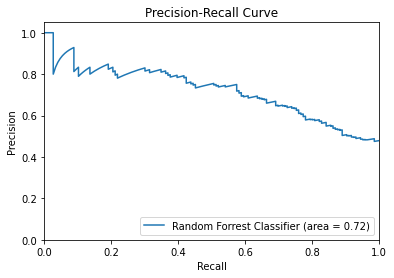

In [45]:
# Grid search for hyperparameters
# Random forest with Recursive feature elimination
rfcv = RFECV(estimator=RandomForestClassifier(random_state = 42))
rfcv.fit(X_train, y_train)
rf_feature = X_train.columns[rfcv.support_]
rfc=RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train[rf_feature], y_train)
y_pred_rf = CV_rfc.predict(X_test[rf_feature])
print ('best parameter: ', CV_rfc.best_params_)
print (len(rf_feature), 'selected features')
plot_AUC(CV_rfc, X_test[rf_feature], y_test)

In [46]:
# selected features
print (len(rf_feature), 'selected features:\n', list(rf_feature))

48 selected features:
 ['days_create2Trial', 'goal_running.health', 'goal_running.injury', 'goal_running.other', 'goal_running.race', 'exp_beginner', 'exp_experienced', 'exp_intermediate', 'b4Trial_ActivityComplete_norm', 'b4Trial_ActivityComplete_ave', 'b4Trial_SessionCompleted_ave', 'b4Trial_SessionCompleted_freq', 'b4Trial_LibrarySelectedTab_norm', 'b4Trial_LibrarySelectedTab_ave', 'b4Trial_LibrarySelectedTab_freq', 'b4Trial_ScreenViewed_norm', 'b4Trial_ScreenViewed_ave', 'b4Trial_ScreenViewed_freq', 'b4Trial_AppForeground_norm', 'b4Trial_AppForeground_ave', 'b4Trial_AppForeground_freq', 'b4Trial_SessionViewed_norm', 'b4Trial_SessionViewed_ave', 'b4Trial_SessionViewed_freq', '7dTrial_ActivityComplete_cons', '7dTrial_ActivityComplete_freq', '7dTrial_SessionCompleted_cons', '7dTrial_SessionCompleted_freq', '7dTrial_LibrarySelectedTab_cons', '7dTrial_LibrarySelectedTab_freq', '7dTrial_ScreenViewed_cons', '7dTrial_ScreenViewed_freq', '7dTrial_AppForeground_cons', '7dTrial_AppForeground_

## 8. Interpreting the model

In [47]:
rf=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 100, max_depth=8, criterion='gini', oob_score = True)
selector = rf.fit(X_train[rf_feature], y_train)

Weight,Feature
0.0186 ± 0.0174,7dTrial_SessionCompleted_freq
0.0154 ± 0.0131,b4Trial_ScreenViewed_freq
0.0141 ± 0.0087,2dTrial_SessionViewed_freq
0.0135 ± 0.0095,2dTrial_SessionCompleted_freq
0.0122 ± 0.0125,7dTrial_LibrarySelectedTab_freq
0.0116 ± 0.0032,2dTrial_ActivityComplete_freq
0.0116 ± 0.0132,2dTrial_ScreenViewed_freq
0.0103 ± 0.0303,7dTrial_SessionViewed_freq
0.0096 ± 0.0129,7dTrial_SessionViewed_cons
0.0084 ± 0.0032,2dTrial_LibrarySelectedTab_freq


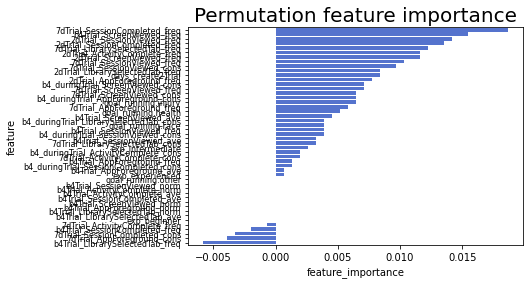

In [51]:
perm = PermutationImportance(rf, random_state=1).fit(X_test[rf_feature], y_test)
perm_imp_eli5 = imp_df(list(rf_feature), perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance', y_sz=1)
eli5.show_weights(perm, feature_names = list(rf_feature))

Top 10 most important features


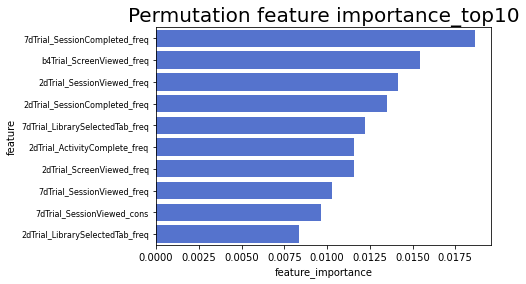

In [50]:
print ('Top 10 most important features')
var_imp_plot(perm_imp_eli5.head(10), 'Permutation feature importance_top10', y_sz=8)

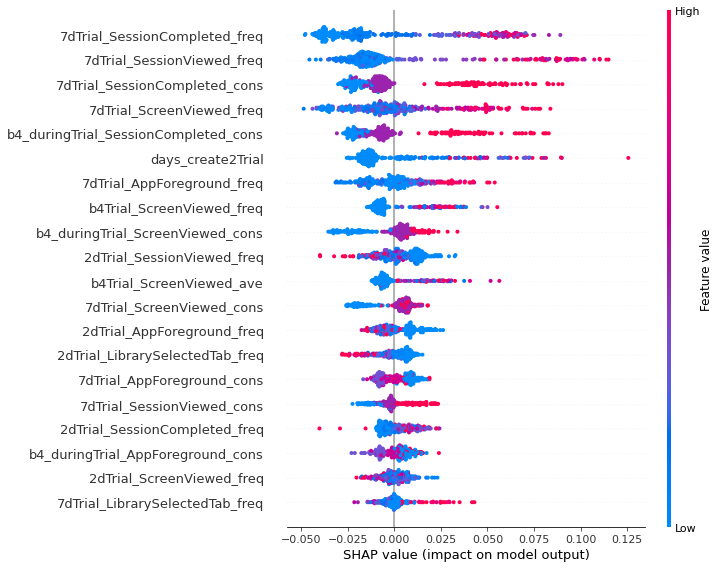

In [53]:
# Feature importance and the impact of their feature value
shap.initjs()
explainer = shap.TreeExplainer(selector)
shap_values = explainer.shap_values(X_test[rf_feature])
f = plt.figure()
shap.summary_plot(shap_values[1], X_test[rf_feature])
f.savefig('../results/shap.png', bbox_inches='tight', dpi=600)

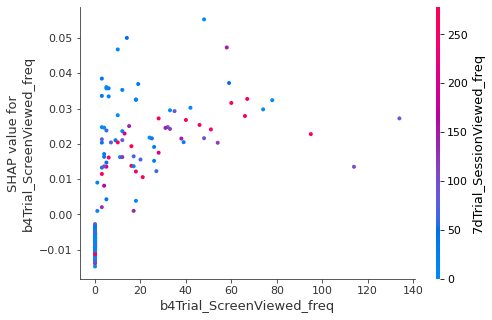

In [96]:
# Feature dependence plot: an interactions of 2 features on prediction
shap.dependence_plot('b4Trial_ScreenViewed_freq', shap_values[1], X_test[rf_feature], interaction_index="7dTrial_SessionViewed_freq")

In [97]:
# explore samples by feature importance similarity
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[rf_feature])

In [107]:
### At user level: how features impact user's probability to convert ###
instance_to_explain = 258
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_to_explain], 
                X_test[rf_feature].iloc[instance_to_explain])